In [43]:
import gym
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import cg, lsqr, spsolve
from scipy.sparse import csc_matrix, lil_matrix

## Newton's method

Newton's method is the most popular method for finding the root of a nonlinear function. Given

$$f(x)$$ and $$\nabla f(x) = g(x),$$

we want to find $x^\star$ such that $f(x^\star) = 0$. For the Taylor series expansion about $x$, we have 

$$f(x_{k+1}) = f(x_k) + g(x)(x_{k+1}-x_k).$$ 

Estimating $f(x_{k+1} = 0$, we have 

$$p = x_{k+1}-x_k = -g(x_k)^{-1}f(x_k).$$ 

To find the root of $f(x)$, we just repeat: 

<br>
$$ \begin{align*}p &= -g(x_k)^{-1}f(x_k)  \\ x_{k+1} &= x_k + p \end{align*}$$

#### Basic Implementation

In [44]:
def newtons_method(f, g, x0, eps=1e-8, max_iters=1000, callback=None, verbose=True): 
    
    x = x0
    
    for it in range(max_iters):
        
        gx = g(x)
        if np.shape(gx):
            p = np.linalg.solve(gx, -f(x))
        else:
            p = -f(x)/gx
                    
        x += p
        
        if callback:
            callback(x)
            
        if np.linalg.norm(p) < eps:
            break
    
    if verbose:
        print(f"Newton's method niters: {it}")
        
    return x

#### Example

Given $f(x, t) = xe^{t} - 5$, find the value of $x$ such that $f(x, 2)=0$. 

* We can use the central difference method to approximate $\nabla f(x)$

Newton's method niters: 26
xstar = 0.6766764260425925
f(xstar) = 7.285261283129785e-08


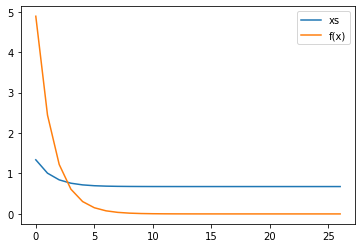

In [45]:
t = 2
b = 5

def f(x):
    return x * np.exp(t) - b

def g(x, h=1e-6):
    return (f(x+h) - f(x-h)) / h

# Save values of x
xs = []
def callback(x):
    xs.append(x)

# initial guess
x0 = 2

# Find xstar
xstar = newtons_method(f, g, x0, callback=callback)

plt.plot(xs, label='xs')
plt.plot(f(np.array(xs)), label='f(x)')
plt.legend()

print(f"xstar = {xstar}")
print(f"f(xstar) = {f(xstar)}")

## Unconstrained Optimization

We can use Newton's method to minimize a function as well. We can approximate some function $F(x)$ by the first three terms of the Taylor series: 

$$
F(x^{k+1}) = F(x^k) + g^T(x^k)p + \frac{1}{2}p^TH(x^k)p,
$$

where $g = \nabla F(x)$, and $H = \nabla^2 F(x)$.
By enforcing $\nabla F(x^{k+1}) = 0$, we have

$$
g(x^k) + H(x^k)p = 0
$$

Therefore, our search direction $p$ is just $p=-H^{-1}g$.

#### Example

Let's minimize $f(x) = x^2 + 10$, for which we know is 10.

In [46]:
def f(x):
    """
    Minimum of this function should be 10
    """
    return x**2 + 10

def g(x, h=1e-6):
    return 1/(2*h) * (f(x+h) - f(x-h))

def H(x, h=1e-6):
    return 1/(h**2) * (f(x + 2*h) - 2*f(x+h) + f(x))
    
x0 = 5
xstar = newtons_method(g, H, x0)

print(f"f(xstar) = {f(xstar)}")
print(f"g(xstar) = {g(xstar)}")
print(f"xstar = {xstar}")

Newton's method niters: 3
f(xstar) = 10.0
g(xstar) = 0.0
xstar = 2.506745779659377e-10


## Optimization with Equality Constraints

Given a function $F(x)$ to minimize, and constraints $c(x)$, define the Lagrangian as 

$$ L(x,\lambda) = F(x) - \lambda^Tc(x).$$

The necessary conditions for an optimal $(x^\star, \lambda^\star)$ are:

$$ \begin{align*}
\nabla L_x &= g - G^T\lambda = 0 \\
\nabla L_\lambda &= -c(x) = 0
\end{align*}
$$

Expanding both equations through the Taylor series, we have 

$$\begin{align*}
0 &= g - G^T\lambda^k + H_L(x^{k+1})(x^{k+1}-x^k) - G^T (\lambda^{k+1}-\lambda^k) \\ &= g +H_Lp - G^T\lambda^{k+1}\\ 0&= -c - G(x^{k+1}-x^k) \\ &= -c - Gp
\end{align*}
$$

This leads to the Karush-Kuhn-Tucker (KKT) system:

$$
\begin{pmatrix} H_L & G^T \\ G & 0 \end{pmatrix} \begin{pmatrix} -p \\ \lambda^k \end{pmatrix} = \begin{pmatrix} g \\ c\end{pmatrix}
$$

In [62]:
def optimize(F, c, g, G, H_L, x0, eps=1e-8, max_iters=1000,
             callback=None, verbose=True):
    
    m = 1 if not np.shape(c(x0)) else len(c(x0))
    n = 1 if not np.shape(x0) else len(x0)
    
    x = x0
    lam = np.random.randn(m)
    
    K = np.zeros((n+m, n+m), dtype=x.dtype)
    
    for it in range(max_iters):
        
        if verbose:
            print(f"--iter: {it}")
        Fx, cx, gx, Gx, H_Lx = F(x), c(x), g(x), G(x), H_L(x, lam)
        Gx = np.atleast_2d(Gx)
                
        K[:n,:n] = H_Lx
        K[:n, n:] = Gx.T
        K[n:,:n] = Gx
        K[n:,n:] = 0
        
        K = csc_matrix(K)
        b = np.block([gx, cx])
        #print(f"--eig(H): {np.linalg.eigvals(H_Lx)}")
        #print(f"--eig(G): {np.linalg.eigvals(Gx)}")
        #print(f"--eig(K): {np.linalg.eigvals(K)}")
        
        #z = lsqr(K, b)[0]
        #z = np.linalg.solve(K, b)
        try:
            z = spsolve(K, b)
        except:
            z = lsqr(K, b)[0]
            
        #z, _ = cg(K, b)
        
        p = -z[:n]
        lam = z[-m:]
        
        x += p
        
        if callback:
            callback(x)
            
        if np.linalg.norm(p) < eps:
            break
    
    if verbose:
        print(f"optimize niters: {it}")
    
    return x

#### Example

Minimize
$$F(x) = x_1^2 + x_2^2$$
subject to
$$
c(x) = x_1 + x_2 - 2 = 0.
$$

The optimal solution to this problem is $x = (1,1)$.

In [63]:
h = 1e-6

def F(x):
    x1, x2 = x
    return x1**2 + x2**2

def c(x):
    x1, x2 = x
    return x1 + x2 - 2

def g(x):
    """
    Gradient of F(x)
    """
    
    n = len(x)
    g_ = np.zeros(n, dtype=x.dtype)
    
    for i in range(n):
        e_i = np.zeros(n)
        e_i[i] = 1
        dx = h * e_i
        g_[i] = 1./(2*h) * (F(x+dx) - F(x-dx))
        
    return g_    
    
def G(x):
    """
    Gradient of c(x)
    """
    
    n = len(x)
    G_ = np.zeros(n, dtype=x.dtype)
    
    for i in range(n):
        e_i = np.zeros(n)
        e_i[i] = 1
        dx = h * e_i
        G_[i] = 1./(2*h) * (c(x+dx) - c(x-dx))
        
    return G_

def L(x, lam):
    return F(x) - np.dot(lam, c(x))

def H_L(x, lam):
    
    n = len(x)
    H_ = np.zeros((n,n), dtype=x.dtype)
    I = np.eye(n)
    
    for i in range(n):
        for j in range(n):
            e_i, e_j = I[:,i], I[:,j]
            a = L(x + h*e_i + h*e_j, lam)
            b = L(x + h*e_i, lam)
            c = L(x + h*e_j, lam)
            d = L(x, lam)
            H_[i,j]=  1./(h**2) * (a - b - c + d)

    return H_

x0 = np.random.randn(2)
xstar = optimize(F, c, g, G, H_L, x0)

print(f"xstar = {xstar}")
print(f"F(xstar) = {F(xstar):.2f}")
print(f"c(xstar) = {c(xstar)}")

--iter: 0
--iter: 1
--iter: 2
optimize niters: 2
xstar = [1. 1.]
F(xstar) = 2.00
c(xstar) = 4.440892098500626e-16


/Users/bsolar/anaconda3/envs/opt-control/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## Solving Differential Equations: Shooting Method

For solving a boundary value problem, we can employ what's called the shooting method. Given

$$ \frac{dy}{dt} = y,$$

suppose we want to find $y(t_I)$ such that $y(t_F) = b$. We have 
$$y(t_F) = y_I + \int_{t_I}^{t_F} y(t) dt.$$

We can approximate this with Euler's method. Our constraint, for which we seek to be zero,is then $c(y_I) = y(t_F) - b$. Again, we can approximate $\nabla c(x)$ by the central difference method. The general steps are:

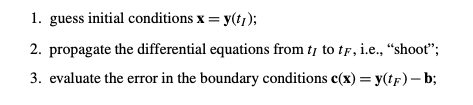

In [64]:
# Some given values
ti = 0
tf = 2
b = 5

def f(y):
    return y

h = 1e-3
ts = np.linspace(ti, tf, math.ceil((tf-ti)/h))

def c(y0):
    yf = y0
    for t in ts:
        yf += h*f(yf)
    return yf - b

def dc(y0):
    return (c(y0 + h) - c(y0 - h))/(2*h)

y0 = 5

ystar = newtons_method(c, dc, y0)

print(f"c(ystar) = {c(ystar)}")
print(f"ystar = {ystar}")

Newton's method niters: 1
c(ystar) = -6.217248937900877e-15
ystar = 0.677352979819864


## Multiple Shooting Method

If $df/dy$ is stiff, then the normal shooting method isn't stable. For example, let $df/dy = 40y$:

In [65]:
# Some given values
ti = 0
tf = 2
b = 5

def f(y):
    return 40*y

h = 1e-3
ts = np.linspace(ti, tf, math.ceil((tf-ti)/h))

def c(y0):
    yf = y0
    for t in ts:
        yf += h*f(yf)
    return yf - b

def dc(y0):
    return (c(y0 + h) - c(y0 - h))/(2*h)

y0 = 5

ystar = newtons_method(c, dc, y0)

print(f"c(ystar) = {c(ystar)}")
print(f"ystar = {ystar}")

Newton's method niters: 1
c(ystar) = -640453943.2046129
ystar = -5.492996255234949e-26


Euler's method diverged and the constraint is very far from 0.

Now imagine that we make additional constraints to force continuity between euler steps. 

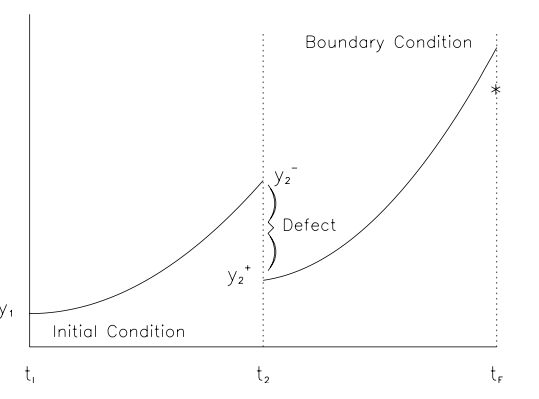

Let's say we have 

$$x^T = (y_1, y_2, \dots, y_n)$$

Our constraints our then:

$$
c(x) = \begin{pmatrix} y_2 - y_1 -hf(y_1) \\ y_3 - y_2 - hf(y_2) \\ \vdots \\ y_n - y_{n-1} - hf(y_{n-1}) \\ y_n - b \end{pmatrix}
$$

Since our constraint is a vector now, we have to find the Jacobian $\nabla c(x) = G(x) \in \mathbb{R}^{n \times n}$. We can likewise do this with the central difference method for each column of $G$:

$$G_i(x) = \frac{1}{2h}(c(x + he_i) - c(x - he_i)),\,\,\,i=1\dots n$$

In [66]:
ti = 0
tf = 2
b = 5

h = 0.01
ts = np.linspace(ti, tf, math.ceil((tf-ti)/h))

def f(y):
    return y

# y = [y1, y2, ... , yn]
def c(ys):
    c_ = np.zeros_like(ys)
    
    for i in range(len(ys)-1):
        c_[i] = ys[i+1] - ys[i] - h*f(ys[i+1])  # defects 
    
    c_[-1] = ys[-1] - b
    
    return c_

def G(ys):
    
    n = len(ys)
    G_ = np.zeros((n,n), dtype=ys.dtype)
    
    for i in range(n):
        e_i = np.zeros(n)
        e_i[i] = 1
        G_[:,i] = 1./(2*h) * (c(ys + h*e_i) - c(ys - h*e_i))
        
    return G_

ys = np.zeros(len(ts))

ystar = newtons_method(c, G, ys)
print(f"||c(ystar)|| = {np.linalg.norm(c(ystar))}")

Newton's method niters: 1
||c(ystar)|| = 2.2296712337065608e-15


#### Sparsity of the Jacobian

For this problem, the Jacobian is very sparse, having only two diagonals. We'll probably want to explore sparsity in the future.

(200, 200)
[[-1.    0.99  0.   ...  0.    0.    0.  ]
 [ 0.   -1.    0.99 ...  0.    0.    0.  ]
 [ 0.    0.   -1.   ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ... -1.    0.99  0.  ]
 [ 0.    0.    0.   ...  0.   -1.    0.99]
 [ 0.    0.    0.   ...  0.    0.    1.  ]]


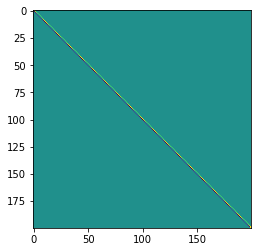

In [67]:
Gstar = G(ystar)
print(Gstar.shape)
print(Gstar)

plt.imshow(Gstar)

## TODO Optimal Control Description

#### TODO Example 1

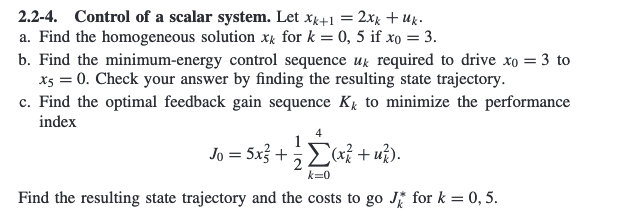

In [68]:
def f(x, u):
    return 2*x + u

N = 5
x0 = 3

# z = [x0, u0, ..., xN-1, u_N-1, xN]
def F(z):
    assert(len(z) % 2 == 1)

    J = 0
    for k in range(0, len(z)-1, 2):
        x, u = z[k], z[k+1]
        J += x**2 + u**2
    J *= 0.5
        
    xN = z[-1]
    J += 5 * xN**2
    
    return J

def g(z):
    
    h = 1e-6
    
    n = len(z)
    
    def e_i(i):
        e = np.zeros(n)
        e[i] = 1
        return e
    
    g_ = np.zeros_like(z)
    
    for i in range(len(z)):
        dz = h * e_i(i)
        g_[i] = 1./(2*h) * (F(z+dz) - F(z-dz))
        
    return g_

def c(z):
    
    c_ = np.zeros(N+1)
    
    k = 0
    for i in range(0, len(z)-1, 2):
        xn, xp = z[i+2], z[i]
        up = z[i+1]
        c_[k] = xn - f(xp, up)
        k += 1
        
    c_[-1] = z[0] - x0
    #c_[-1] = z[-1]
    
    return c_

def G(z):
    
    h = 1e-6
    
    n = len(z)
    G_ = np.zeros((N+1,n), dtype=z.dtype)
    
    def e_i(i):
        e = np.zeros(n)
        e[i] = 1
        return e
    
    for i in range(n):
        G_[:,i] = 1./(2*h) * (c(z + h*e_i(i)) - c(z - h*e_i(i)))
        
    return G_


def L(z, lam):
    return F(z) - np.dot(lam, c(z))


def H(z, func):
    
    n = len(z)
    
    H_ = np.zeros((n,n), dtype=z.dtype)
    
    h = 1e-6
    
    I = np.eye(n)
    
    for i in range(n):
        for j in range(n):
            e_i, e_j = I[:,i], I[:,j]
            a = func(z + h*e_i + h*e_j)
            b = func(z + h*e_i)
            c = func(z + h*e_j)
            d = func(z)
            H_[i,j]=  1./(h**2) * (a - b - c + d)

    return H_


def H_L(z, lam): 
    H_ = H(z, lambda z: L(z, lam))
    return H_

z0 = np.zeros(2*N+1)

zstar = optimize(F, c, g, G, H_L, z0)

print(f"F(zstar) = {F(zstar):.2f}")
print(f"||c(xstar)|| = {np.linalg.norm(c(zstar))}")

--iter: 0
--iter: 1
--iter: 2
--iter: 3
--iter: 4
optimize niters: 4
F(zstar) = 19.06
||c(xstar)|| = 8.090007123710897e-16


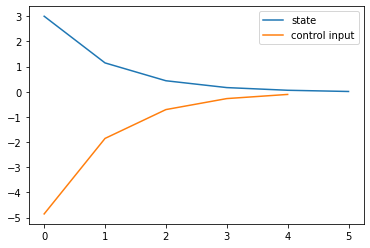

In [69]:
x = zstar[::2]
u = zstar[1::2]
plt.plot(x, label='state')
plt.plot(u, label='control input')
plt.legend()

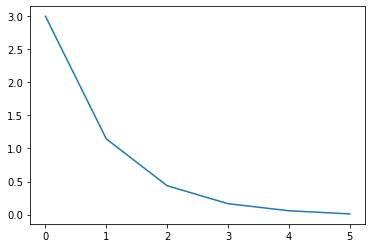

In [70]:
xs = [x0]
for u_ in u:
    xs.append(f(xs[-1], u_))
    
plt.plot(xs)

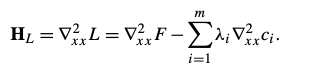

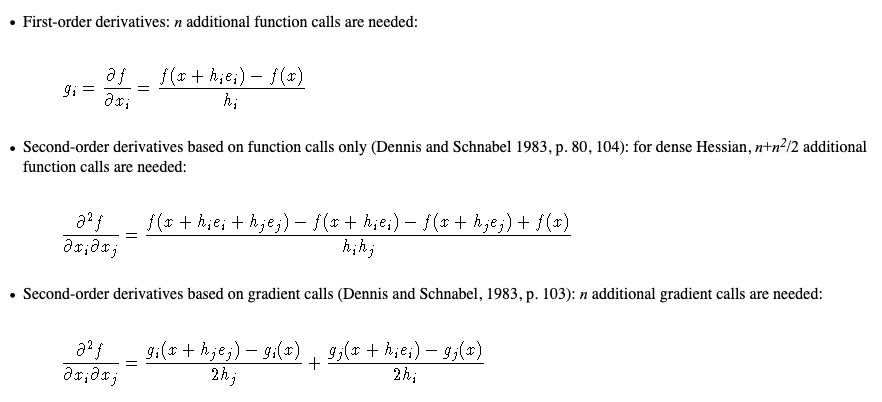

In [71]:
class X(np.ndarray):
    """
    Data class for wrapping the vector [x0,x1...,xN, u0,...uN-1]
    """
    
    def __new__(cls, input_array, state_dim, input_dim):
        obj = np.asarray(input_array).view(cls)
        obj.state_dim = state_dim
        obj.input_dim = input_dim
        obj.n = (len(input_array) - state_dim) // (state_dim + input_dim)
        obj.input_idx = (obj.n + 1) * state_dim
        return obj
    
    def __array_finalize__(self, obj):
        if obj is None: return
        
        state_dim = getattr(obj, 'state_dim', None)
        input_dim = getattr(obj, 'input_dim', None)
        
        if state_dim and input_dim:
            assert(len(self) % (state_dim + input_dim) == state_dim)

            self.state_dim = state_dim
            self.input_dim = input_dim

            # (n+1)*state_dim + n*input_dim = len(z0)
            # n*state_dim + n*input_dim = len(z0) - state_dim
            self.n = (len(self) - state_dim) // (state_dim + input_dim)

            self.input_idx = (self.n+1) * state_dim
      
    def x(self, idx):
        
        if idx >= 0:
            assert(idx < self.input_idx // self.state_dim)
            idx = self.idx_to_slice(idx, self.state_dim)
            return self[idx]
        else:
            assert(abs(idx) - 1 < self.input_idx // self.state_dim)
            idx = self.idx_to_slice(idx, self.state_dim, self.input_idx)
            return self[idx]
    
    def u(self, idx):
        
        if idx >= 0:
            assert((len(self) - self.input_idx) // self.input_dim > idx)
            idx = self.idx_to_slice(idx, self.input_dim, self.input_idx)
            return self[idx]
        else:
            assert((len(self) - self.input_idx) // self.input_dim > abs(idx)-1)
            idx = self.idx_to_slice(idx, self.input_dim)
            return self.z[idx]
        
    def idx_to_slice(self, idx, dim, starting_idx=0):
        if dim == 1:
            return idx
        else:
            if idx >= 0:
                beg_idx = dim*idx + starting_idx
                end_idx = beg_idx + dim
                return slice(beg_idx, end_idx)
            else:
                beg_idx = dim*idx + starting_idx
                end_idx = beg_idx + dim
                if end_idx == 0:
                    end_idx = None
                return slice(beg_idx, end_idx)

#### TODO Example 2: Inverted Pendulum

Still needs a lot of work

In [ ]:
grav = 9.8
m = l = 1
mu = 0.01

state_dim = 2
input_dim = 1

N = 40
z = np.random.randn((N+1)*state_dim + N*input_dim)
z0 = X(z, state_dim, input_dim)

h = 1e-4

def f(x, u):
    x1, x2 = x
    theta_dot = x2
    theta_ddot = grav/l * np.sin(x1) - mu/(m*l**2)*x2 + 1/(m*l**2)*u
    return np.array([theta_dot, theta_ddot])
    
def F(z):
    N = z.n
    r = 1e-5
    
    J = 0
    for i in range(N):
        J += r*z.u(i)**2
    J *= 0.5
    
    x1_final, x2_final = z.x(-1)
    J += 0.5 * (x1_final**2 + x2_final**2)
    
    return J


def g(z):
        
    n = len(z)
    
    def e_i(i):
        e = np.zeros(n)
        e[i] = 1
        return e
    
    g_ = np.zeros_like(z)
    
    for i in range(len(z)):
        dz = h * e_i(i)
        g_[i] = 1./(2*h) * (F(z+dz) - F(z-dz))
        
    return g_
    

def c(z):
    
    c_ = np.zeros((z.n+2)*z.state_dim)
    
    k = 0
    for i in range(z.n):
        xn, xp = z.x(i), z.x(i+1)
        up = z.u(i)
        
        c_[k:k+z.state_dim] = xn - 0.05*f(xp, up)
        k += z.state_dim
    
    c_[-4:-2] = z.x(-1)
    c_[-2] = z.x(0)[0] - np.deg2rad(180)
    c_[-1] = z.x(0)[1]
    return c_

def G(z):
        
    n = len(z)
    G_ = np.zeros(((z.n+2)*z.state_dim,n), dtype=z.dtype)
    
    def e_i(i):
        e = np.zeros(n)
        e[i] = 1
        return e
    
    for i in range(n):
        G_[:,i] = 1./(2*h) * (c(z + h*e_i(i)) - c(z - h*e_i(i)))
        
    return G_


def L(z, lam):
    return F(z) - np.dot(lam, c(z))


def H(z, func):
    
    n = len(z)
    
    H_ = np.zeros((n,n), dtype=z.dtype)
        
    I = np.eye(n)
    
    for i in range(n):
        for j in range(n):
            e_i, e_j = I[:,i], I[:,j]
            a = func(z + h*e_i + h*e_j)
            b = func(z + h*e_i)
            c = func(z + h*e_j)
            d = func(z)
            H_[i,j]=  1./(h**2) * (a - b - c + d)

    return H_


def H_L(z, lam): 
    H_ = H(z, lambda z: L(z, lam))
    return H_

zstar = optimize(F, c, g, G, H_L, z0)

print(f"F(zstar) = {F(zstar):.2f}")
print(f"||c(xstar)|| = {np.linalg.norm(c(zstar))}")

--iter: 0


/Users/bsolar/anaconda3/envs/opt-control/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


--iter: 1


/Users/bsolar/anaconda3/envs/opt-control/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


--iter: 2
--iter: 3
--iter: 4
--iter: 5
--iter: 6
--iter: 7
--iter: 8
--iter: 9
--iter: 10
--iter: 11
--iter: 12
--iter: 13
--iter: 14
--iter: 15
--iter: 16
--iter: 17
--iter: 18
--iter: 19
--iter: 20
--iter: 21


In [ ]:
xs = []
ys = []
for i in range(zstar.n+1):
    theta = zstar.x(i)[0]
    xs.append(np.cos(theta))
    ys.append(np.sin(theta))
    print(theta)
    
plt.scatter(xs, ys)

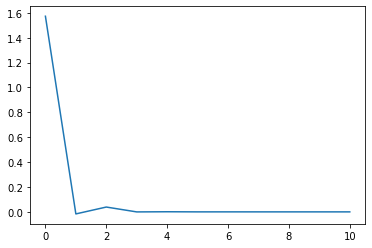

In [523]:
plt.plot(thetas)